In [1]:
from typing import List, Tuple, Dict, Any, Optional, Callable

import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

import numpy as np
import pandas as pd
import pyspark
import pyspark.sql.functions as F
import os
import random

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StructField, StructType, StringType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
spark = SparkSession.builder\
.config("spark.driver.memory", "6g")\
.appName("diabetes_indicators").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 13:12:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("./data/diabetes/final_diabetes_dataset.csv", header=True, inferSchema=True, sep=",")
df.show(5)

+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|DIABETE3|CHCKIDNY|_RFHYPE5|TOLDHI2| _BMI5|SMOKE100|CVDSTRK3|_MICHD|_TOTINDA|_FRTLT1|_VEGLT1|_RFDRHV5|MEDCOST|GENHLTH|PHYSHLTH|MENTHLTH|SEX|_AGEG5YR|_MRACE1|EDUCA|INCOME2|
+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|       0|       0|       1|      1|2522.0|       1|       0|     0|       1|      1|      1|       0|      0|    2.0|     2.0|    88.0|  0|    10.0|    1.0|  6.0|    8.0|
|       0|       0|       0|      0|2407.0|       0|       0|     0|       0|      0|      1|       0|      0|    2.0|    88.0|    88.0|  0|     8.0|    1.0|  4.0|    3.0|
|       2|       0|       0|      0|2468.0|       1|       0|     0|       1|      1|      1|       0|      0|    3.0|    88.0|    88.0|  0|

In [4]:
df = df.limit(100_000)

# Feature Scaling and Transformation

In [5]:
def transform_data(df: pyspark.sql.DataFrame, map_dict: dict, colName: str) -> pyspark.sql.DataFrame:
    """ Function to transform predictor variable based on map_dict """
    map_col = F.create_map([F.lit(x) for i in map_dict.items() for x in i])
    new_df = df.withColumn(colName, map_col[F.col(colName)])
    
    return new_df

In [6]:
df = df.withColumn("PHYSHLTH", F.when(df["PHYSHLTH"] == 88, 0).otherwise(df["PHYSHLTH"]))
df = df.withColumn("MENTHLTH", F.when(df["MENTHLTH"] == 88, 0).otherwise(df["MENTHLTH"]))

df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 14))}, "_AGEG5YR")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 8))}, "_MRACE1")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 7))}, "EDUCA")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 9))}, "INCOME2")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 6))}, "GENHLTH")

In [7]:
def scale_data(df: pyspark.sql.DataFrame, feats: List) -> pyspark.sql.DataFrame: 
    """ Function to scale the data """
    def scale_feat(df: pyspark.sql.DataFrame, feat: str) -> pyspark.sql.DataFrame:
        """ Function to scale numeric columns of dataframe """
        unlist = F.udf(lambda x: round(float(list(x)[0]), 3), DoubleType())

        assembler = VectorAssembler(inputCols=[feat], outputCol=feat+"_vec")
        scaler = StandardScaler(inputCol=feat+"_vec", outputCol=feat+"_scaled")
        pipeline = Pipeline(stages=[
            assembler,
            scaler
        ])

        if not os.path.exists(f"./scalers/{feat}_pipeline"):
            pipeline_model = pipeline.fit(df)
            pipeline_model.save(f"./scalers/{feat}_pipeline")

        else:
            print(f"Loading pipeline from : ./scalers/{feat}_pipeline")
            pipeline_model = PipelineModel.load(f"./scalers/{feat}_pipeline")

        df = pipeline_model.transform(df).withColumn(feat+"_scaled", unlist(feat+"_scaled")).drop(feat+"_vec")

        return df, feat+"_scaled"
    
    new_feats = list()
    for feat in feats:
        df, _name = scale_feat(df, feat)
        new_feats.append(_name)
        
    return df, new_feats

In [8]:
if not os.path.exists("./scalers/"):
    os.mkdir("./scalers")


num_cols = ["_BMI5", "PHYSHLTH", "MENTHLTH"]
cat_cols = [x for x in df.columns if x not in ["DIABETE3"]+num_cols]

df_train, df_test = df.randomSplit([.8, .2], seed=42)

In [9]:
df_train_scaled, train_new_feats = scale_data(df_train, num_cols)
df_test_scaled, test_new_feats = scale_data(df_test, num_cols)

df_train_scaled = df_train_scaled.withColumnRenamed("DIABETE3", "label")
df_test_scaled = df_test_scaled.withColumnRenamed("DIABETE3", "label")

Loading pipeline from : ./scalers/_BMI5_pipeline
Loading pipeline from : ./scalers/PHYSHLTH_pipeline
Loading pipeline from : ./scalers/MENTHLTH_pipeline
Loading pipeline from : ./scalers/_BMI5_pipeline
Loading pipeline from : ./scalers/PHYSHLTH_pipeline
Loading pipeline from : ./scalers/MENTHLTH_pipeline


In [10]:
df_train_scaled = df_train_scaled.repartition(20)

In [11]:
dtree = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=32)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=32)
log_reg = LogisticRegression(featuresCol="features", labelCol="label", standardization=True)

In [12]:
paramGrid_dtree = ParamGridBuilder() \
.addGrid(dtree.maxDepth, [5, 10, 15, 20])\
.build()

paramGrid_rf = ParamGridBuilder()\
.addGrid(rf.maxDepth, [5, 10, 15, 20])\
.build()

paramGrid_logreg = ParamGridBuilder()\
.addGrid(log_reg.maxIter, [20, 50, 100])\
.addGrid(log_reg.tol, [1e-2, 1e-4, 1e-6])\
.addGrid(log_reg.threshold, [.5, .7])\
.build()

In [13]:
pipeline_dtree = Pipeline(
    stages=[
        VectorAssembler(inputCols=cat_cols + train_new_feats, outputCol="features"),
        dtree
    ]
)

pipeline_rf = Pipeline(
    stages=[
        VectorAssembler(inputCols=cat_cols + train_new_feats, outputCol="features"),
        rf
    ]
)

pipeline_logreg = Pipeline(
    stages=[
        VectorAssembler(inputCols=cat_cols + train_new_feats, outputCol="features"),
        log_reg
    ]
)

# Model Cross-Validation

## - Decision Tree

In [14]:
crossval_dtree = CrossValidator(estimator=pipeline_dtree, 
                               estimatorParamMaps=paramGrid_dtree, 
                               evaluator=MulticlassClassificationEvaluator(),
                               numFolds=3)
cvmodel_dtree = crossval_dtree.fit(df_train_scaled)

23/10/12 10:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB
23/10/12 10:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB
23/10/12 10:37:04 WARN DAGScheduler: Broadcasting large task binary with size 1274.2 KiB
23/10/12 10:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1519.3 KiB
23/10/12 10:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1760.7 KiB
23/10/12 10:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1995.2 KiB
23/10/12 10:37:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/10/12 10:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1412.0 KiB
23/10/12 10:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB
23/10/12 10:39:09 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB
23/10/12 10:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1260.5 KiB
23/10/12 10:39:15 WARN D

In [15]:
cvmodel_dtree.avgMetrics

[0.7912102002347752, 0.7933607056277938, 0.7797563972636286, 0.76369564240532]

## - Random Forest

In [16]:
crossval_rf = CrossValidator(estimator=pipeline_rf, 
                               estimatorParamMaps=paramGrid_rf, 
                               evaluator=MulticlassClassificationEvaluator(),
                               numFolds=3)
cvmodel_rf = crossval_rf.fit(df_train_scaled)

23/10/12 10:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1488.2 KiB
23/10/12 10:41:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/10/12 10:41:16 WARN DAGScheduler: Broadcasting large task binary with size 1573.8 KiB
23/10/12 10:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1488.2 KiB
23/10/12 10:41:38 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/10/12 10:41:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/10/12 10:42:04 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/10/12 10:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
23/10/12 10:42:25 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
23/10/12 10:42:44 WARN DAGScheduler: Broadcasting large task binary with size 1237.0 KiB
23/10/12 10:42:51 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
23/10/12 10:43:13 WARN DAGScheduler: B

In [17]:
cvmodel_rf.avgMetrics

[0.7585544594555061,
 0.7870592152906328,
 0.7943679202221721,
 0.7967513844578309]

In [28]:
crossval_log_reg = CrossValidator(estimator=pipeline_logreg, 
                               estimatorParamMaps=paramGrid_logreg, 
                               evaluator=MulticlassClassificationEvaluator(),
                               numFolds=3)
cvmodel_log_reg = crossval_log_reg.fit(df_train_scaled)

23/10/12 11:20:28 WARN CacheManager: Asked to cache already cached data.
23/10/12 11:20:28 WARN CacheManager: Asked to cache already cached data.
23/10/12 11:20:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/12 11:20:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [30]:
cvmodel_log_reg.avgMetrics

[0.7943157207658739,
 0.7943157207658739,
 0.7936749154071325,
 0.7936749154071325,
 0.7936749154071325,
 0.7936749154071325,
 0.7943157207658739,
 0.7943157207658739,
 0.7936801529260931,
 0.7936801529260931,
 0.7936887999328142,
 0.7936887999328142,
 0.7943157207658739,
 0.7943157207658739,
 0.7936801529260931,
 0.7936801529260931,
 0.7936887999328142,
 0.7936887999328142]

# Data Modelling (on complete Train set)

In [39]:
rf2 = RandomForestClassifier(featuresCol="features", labelCol="label",
                                 maxDepth=20, numTrees=20, seed=32)
pipeline_rf2 = Pipeline(
    stages=[
        VectorAssembler(inputCols=cat_cols + train_new_feats, outputCol="features"),
        rf2
    ]
)

In [40]:
rf_model = pipeline_rf2.fit(df_train_scaled)

23/10/12 14:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1542.0 KiB
23/10/12 14:09:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/10/12 14:09:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/10/12 14:09:33 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/10/12 14:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1197.7 KiB
23/10/12 14:09:41 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
23/10/12 14:09:47 WARN DAGScheduler: Broadcasting large task binary with size 1541.2 KiB
23/10/12 14:09:50 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
23/10/12 14:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1839.1 KiB
23/10/12 14:10:02 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB
23/10/12 14:10:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/10/12 14:10:17 WARN DAGScheduler: Bro

In [41]:
test_predictions = rf_model.transform(df_test_scaled)
acc_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")

rf_acc_eval = acc_evaluator.evaluate(test_predictions)
rf_f1_eval = f1_evaluator.evaluate(test_predictions)

print("Results on Test set: ")
print("-"*20)
print(f"Accuracy: {rf_acc_eval}")
print(f"F1: {rf_f1_eval}")
print("-"*20)

23/10/12 14:12:08 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
23/10/12 14:12:13 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB


Results on Test set: 
--------------------
Accuracy: 0.8345688840240808
F1: 0.7991226042855168
--------------------


In [42]:
rf_model.stages[1].featureImportances

SparseVector(20, {0: 0.0175, 1: 0.0582, 2: 0.0314, 3: 0.0293, 4: 0.0137, 5: 0.0253, 6: 0.0284, 7: 0.0322, 8: 0.0291, 9: 0.0122, 10: 0.0166, 11: 0.0863, 13: 0.1169, 14: 0.0391, 15: 0.0648, 16: 0.087, 17: 0.171, 18: 0.0809, 19: 0.0602})

In [43]:
feat_cols = cat_cols + train_new_feats
rf_feat_imp = rf_model.stages[1].featureImportances

feature_importance = [(feat, float(rf_feat_imp[idx])) for idx, feat in enumerate(feat_cols)]
feature_importance

[('CHCKIDNY', 0.017472141153498547),
 ('_RFHYPE5', 0.05816656084851104),
 ('TOLDHI2', 0.03137401396359205),
 ('SMOKE100', 0.02934674293736463),
 ('CVDSTRK3', 0.013690054719408946),
 ('_MICHD', 0.025267877220373203),
 ('_TOTINDA', 0.02839284317571737),
 ('_FRTLT1', 0.03223459479903599),
 ('_VEGLT1', 0.029055672202848232),
 ('_RFDRHV5', 0.012205501243057264),
 ('MEDCOST', 0.016577593636003574),
 ('GENHLTH', 0.08627208732974928),
 ('SEX', 0.0),
 ('_AGEG5YR', 0.11685519143209815),
 ('_MRACE1', 0.03906514442402025),
 ('EDUCA', 0.06482972381937366),
 ('INCOME2', 0.08701565349361218),
 ('_BMI5_scaled', 0.17099624058783286),
 ('PHYSHLTH_scaled', 0.08094566004358734),
 ('MENTHLTH_scaled', 0.06023670297031545)]

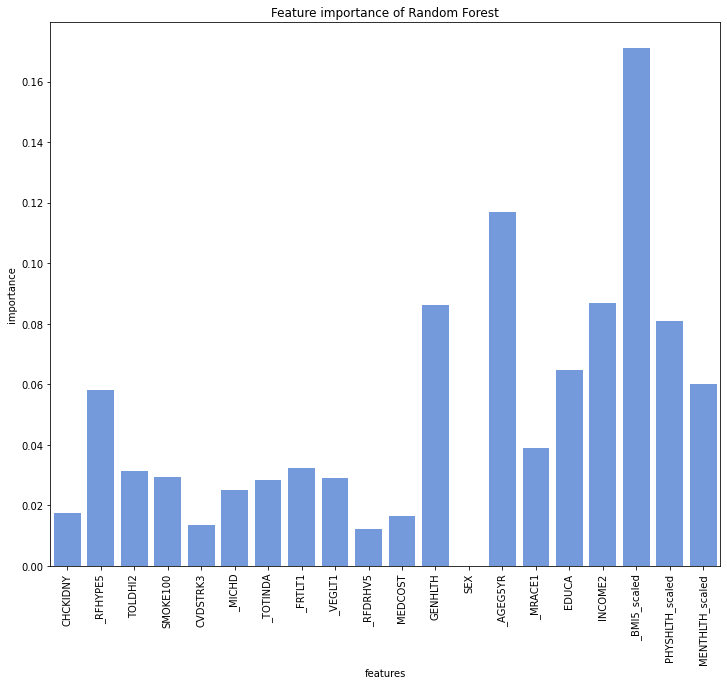

In [44]:
feature_importance_df = spark.createDataFrame(data=feature_importance,
                                             schema=StructType([
                                                 StructField("features", StringType(), True),
                                                 StructField("importance", FloatType(), True)
                                             ]))
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
plt.title("Feature importance of Random Forest")
sns.barplot(x="features", y="importance", data=feature_importance_df.toPandas(), color="cornflowerblue")
plt.xticks(rotation=90)
plt.show()

In [45]:
preds_labels = test_predictions.select(["prediction", "label"])\
.withColumn("label", F.col("label").cast(FloatType()))\
.orderBy("prediction")

conf_mat_metric = MulticlassMetrics(preds_labels.rdd.map(tuple))
conf_mat_metric.confusionMatrix().toArray()

23/10/12 14:12:19 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
23/10/12 14:12:22 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/10/12 14:12:26 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB
23/10/12 14:12:27 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


array([[1.6171e+04, 1.0000e+00, 5.7600e+02],
       [3.0600e+02, 0.0000e+00, 3.9000e+01],
       [2.4030e+03, 0.0000e+00, 6.0300e+02]])

In [46]:
cm_results = test_predictions.crosstab("prediction", "label")\
.toPandas()\
.sort_values(by=["prediction_label"])
cm_results

23/10/12 14:12:30 WARN DAGScheduler: Broadcasting large task binary with size 24.3 MiB
23/10/12 14:12:36 WARN DAGScheduler: Broadcasting large task binary with size 24.2 MiB


,prediction_label,0,1,2
2,0.0,16171,306,2403
1,1.0,1,0,0
0,2.0,576,39,603


In [50]:
conf_mat_metric.falsePositiveRate(0.), conf_mat_metric.truePositiveRate(0.)

(0.8084153983885407, 0.9655481251492716)

In [51]:
conf_mat_metric.falsePositiveRate(1.), conf_mat_metric.truePositiveRate(1.)

(5.062265870203503e-05, 0.0)

In [52]:
conf_mat_metric.falsePositiveRate(2.), conf_mat_metric.truePositiveRate(2.)

(0.03597964078862692, 0.20059880239520958)

# RF Data Modelling with Oversampling

In [15]:
def oversample(df: pyspark.sql.DataFrame, minoritylabel: int) -> pyspark.sql.DataFrame:
    """ Function to oversample the minority classes """
    
    majority_df = df_train_scaled.filter(F.col("label") == 0)
    minority_df = df_train_scaled.filter((F.col("label") == minoritylabel))
    ratio = int(majority_df.count() / minority_df.count())
    
    oversampled_df = minority_df.withColumn("dummy", 
                                           F.explode(
                                               F.array([F.lit(x) for x in range(ratio)])
                                           )).drop("dummy")
    
    return oversampled_df

In [20]:
df_minority_1 = oversample(df_train_scaled, 1)
df_minority_2 = oversample(df_train_scaled, 2)

df_oversampled_scaled = df_train_scaled.filter(F.col("label") == 0).union(df_minority_1)
df_oversampled_scaled = df_oversampled_scaled.union(df_minority_2)

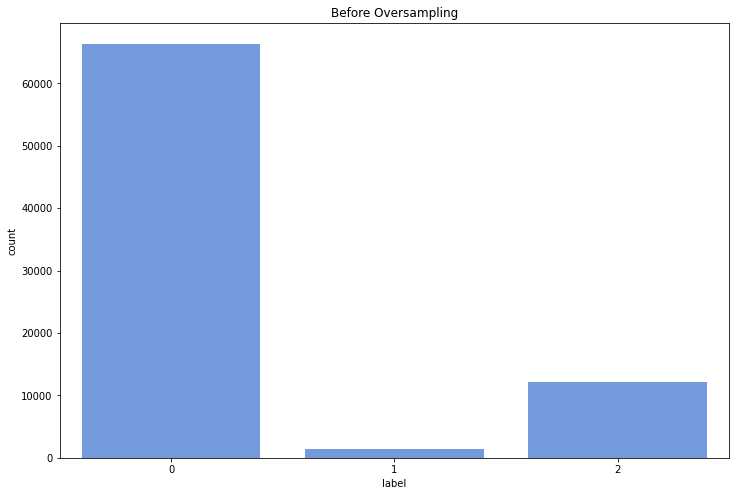

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Before Oversampling")
sns.countplot(x="label", data=df_train_scaled.select("label").toPandas(), color="cornflowerblue")
plt.show()

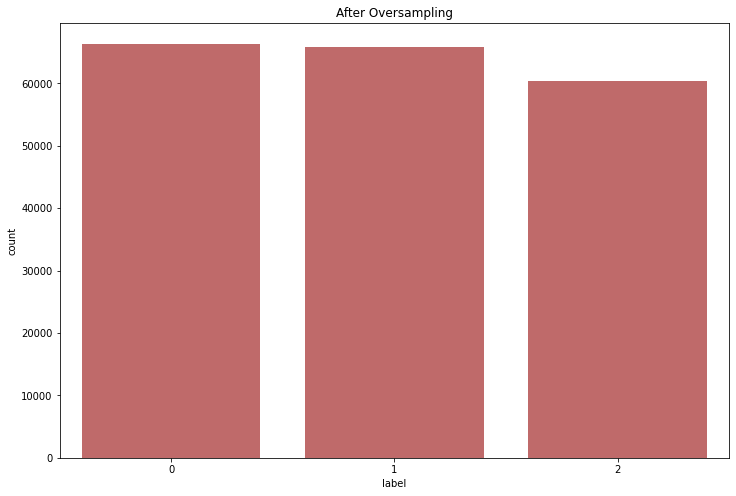

In [24]:
plt.figure(figsize=(12, 8))
plt.title("After Oversampling")
sns.countplot(x="label", data=df_oversampled_scaled.select("label").toPandas(), color="indianred")
plt.show()

In [29]:
rf3 = RandomForestClassifier(featuresCol="features", labelCol="label",
                                 maxDepth=20, numTrees=50, seed=32)
pipeline_rf3 = Pipeline(
    stages=[
        VectorAssembler(inputCols=cat_cols + train_new_feats, outputCol="features"),
        rf3
    ]
)

In [30]:
rf_model2 = pipeline_rf3.fit(df_oversampled_scaled)

23/10/12 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB
23/10/12 13:42:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/10/12 13:42:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/12 13:43:04 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/10/12 13:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1609.0 KiB
23/10/12 13:43:27 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
23/10/12 13:43:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/10/12 13:44:01 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
23/10/12 13:44:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/10/12 13:44:50 WARN DAGScheduler: Broadcasting large task binary with size 27.1 MiB
23/10/12 13:45:41 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/12 13:46:00 WARN DAGScheduler: Broadcas

In [31]:
test_predictions2 = rf_model2.transform(df_test_scaled)
acc_evaluator2 = MulticlassClassificationEvaluator(metricName="accuracy")
f1_evaluator2 = MulticlassClassificationEvaluator(metricName="f1")

rf_acc_eval2 = acc_evaluator2.evaluate(test_predictions2)
rf_f1_eval2 = f1_evaluator2.evaluate(test_predictions2)

print("Results on Test set: ")
print("-"*20)
print(f"Accuracy: {rf_acc_eval2}")
print(f"F1: {rf_f1_eval2}")
print("-"*20)

23/10/12 14:04:35 WARN DAGScheduler: Broadcasting large task binary with size 82.7 MiB
23/10/12 14:04:46 WARN DAGScheduler: Broadcasting large task binary with size 82.7 MiB


Results on Test set: 
--------------------
Accuracy: 0.7843673814617642
F1: 0.7910107293671006
--------------------


In [32]:
preds_labels2 = test_predictions2.select(["prediction", "label"])\
.withColumn("label", F.col("label").cast(FloatType()))\
.orderBy("prediction")

conf_mat_metric2 = MulticlassMetrics(preds_labels2.rdd.map(tuple))
conf_mat_metric2.confusionMatrix().toArray()

23/10/12 14:05:03 WARN DAGScheduler: Broadcasting large task binary with size 82.6 MiB
23/10/12 14:05:11 WARN DAGScheduler: Broadcasting large task binary with size 82.6 MiB
23/10/12 14:05:21 WARN DAGScheduler: Broadcasting large task binary with size 82.6 MiB
23/10/12 14:05:26 WARN DAGScheduler: Broadcasting large task binary with size 82.6 MiB


array([[1.431e+04, 1.890e+02, 2.249e+03],
       [2.240e+02, 5.000e+00, 1.160e+02],
       [1.516e+03, 4.000e+01, 1.450e+03]])

In [34]:
cm_results2 = test_predictions2.crosstab("prediction", "label")\
.toPandas()\
.sort_values(by=["prediction_label"])
cm_results2

23/10/12 14:05:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/12 14:05:46 WARN DAGScheduler: Broadcasting large task binary with size 82.7 MiB
23/10/12 14:06:01 WARN DAGScheduler: Broadcasting large task binary with size 82.6 MiB


,prediction_label,0,1,2
2,0.0,14310,224,1516
1,1.0,189,5,40
0,2.0,2249,116,1450


In [36]:
conf_mat_metric2.falsePositiveRate(0.), conf_mat_metric2.truePositiveRate(0.)

(0.5192479856759177, 0.8544303797468354)

In [37]:
conf_mat_metric2.falsePositiveRate(1.), conf_mat_metric2.truePositiveRate(1.)

(0.011592588842766023, 0.014492753623188406)

In [38]:
conf_mat_metric2.falsePositiveRate(2.), conf_mat_metric2.truePositiveRate(2.)

(0.13836073246358158, 0.4823685961410512)